## HOG+SVM
このノートブックではHOG(Histgrams of Oriented Gradients)特徴量とSVMを用いて車の検出を行う. 

データ : https://cogcomp.seas.upenn.edu/Data/Car/ 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm

In [10]:
from skimage.feature import hog

In [11]:
def load_data(path,negpos,iter_num):
    """車の画像データを読み込む関数
    
    Args:
    path : 画像のパス
    negpos : 正例(True)か負例(False)か
    iter_num : ループ回数
    """
    WINDOW_W = 100
    WINDOW_H = 40
    hogValueList = [] # HOG特徴量ベクトルのリスト
    labelList = [] # negative or positive
    if negpos: # Trueのとき
        np = "pos-"
        label = "positive"
    else:
        np = "neg-"
        label = "negative"
        
    for i in tqdm(range(iter_num+1)):
        fname = path+np+str(i)+".pgm"
        img = cv2.imread(fname)
        # 画像を平面化
        img2d = img[:,:,0]
        img2d = img2d[0:WINDOW_H,0:WINDOW_W]
        #print(img2d.shape)
        #plt.imshow(img2d,cmap="gray")
        #plt.show()
        
        # 画像からHOG特徴量を計算
        # orientations : ヒストグラムのビンの数
        # pixels_per_cell : セルの数
        # cells_per_block : 1ブロックあたりのセルの数
        hogValue = hog(img2d, block_norm='L2',orientations=9, pixels_per_cell=(6,6),cells_per_block=(3,3))
        hogValueList.append(hogValue)
        
        # ラベル代入
        labelList.append(label)
    return hogValueList,labelList

### load_data

In [12]:
train_path = "./Data/TrainImages/"
test_path = "./Data/TestImages/"

POS_FILE_NUM = 549
NEG_FILE_NUM = 499

posHogValueList,posLabelList = load_data(train_path,True,POS_FILE_NUM) # positive train data
negHogValueList,negLabelList = load_data(train_path,False,NEG_FILE_NUM) # negative train data
HogValueList = posHogValueList+negHogValueList
LabelList = posLabelList+negLabelList

<ipython-input-11-5afff95faabc>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iter_num+1)):


  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### modeling

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle

In [6]:
params_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
    ]

model = SVC()
search = GridSearchCV(model,params_grid,cv=5,n_jobs=-1)
search.fit(HogValueList,LabelList)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['sigmoid']}])

In [7]:
print(search.best_params_)
print(search.best_score_)
# モデルの保存
with open('model.pickle', mode='wb') as f:
    pickle.dump(search,f,protocol=2)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.9885714285714287


## 検出

In [14]:
# IoUの計算
def iou(a, b):
    """IoUを計算する関数
    
    Args:
    a:(x,y,x+WIDTH,y+HEIGHT)
    b:(x,y,x+WIDTH,y+HEIGHT)
    """
    a_x1, a_y1, a_x2, a_y2 = a
    b_x1, b_y1, b_x2, b_y2 = b
    
    if a == b:
        return 1.0
    elif (
        (a_x1 <= b_x1 and a_x2 > b_x1) or (a_x1 >= b_x1 and b_x2 > a_x1)
    ) and (
        (a_y1 <= b_y1 and a_y2 > b_y1) or (a_y1 >= b_y1 and b_y2 > a_y1)
    ):
        intersection = (min(a_x2, b_x2) - max(a_x1, b_x1)) * (min(a_y2, b_y2) - max(a_y1, b_y1))
        union = (a_x2 - a_x1) * (a_y2 - a_y1) + (b_x2 - b_x1) * (b_y2 - b_y1) - intersection
        return intersection / union
    else:
        return 0.0
    
# Non-Maximun Suppressionを計算
def nms(bboxes, scores, iou_threshold):
    """NMSを計算する関数
    
    Args:
    bboxes : Bounding box のリスト
    scores : 再現率
    iou_threshold : 閾値
    """
    new_bboxes = []
    
    while len(bboxes) > 0:
        i = scores.index(max(scores))
        bbox = bboxes.pop(i)
        scores.pop(i)
        
        deletes = []
        for j, (bbox_j, score_j) in enumerate(zip(bboxes, scores)):
            if iou(bbox, bbox_j) > iou_threshold:
                deletes.append(j)
                
        for j in deletes[::-1]:
            bboxes.pop(j)
            scores.pop(j)
                
        new_bboxes.append(bbox)
        
    return new_bboxes

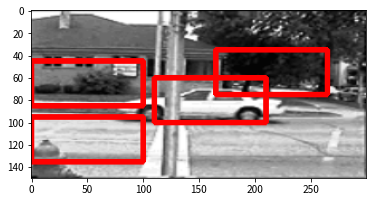

In [15]:
# 検出するテストデータのインデックス
index = 79

# モデルのオープン
with open('model.pickle', mode='rb') as f:
    detecter = pickle.load(f)
    
# スライディングウィンドウの大きさ
WINDOW_W = 100
WINDOW_H = 40
    
# 画像サイズ
IMG_W = 300
IMG_H = 150

# ステップサイズ
STEP_W = 5
STEP_H = 5
path = test_path+"test-"+str(index)+".pgm"
test_img = cv2.imread(path)
test_img = test_img[:,:,0]
test_img = cv2.resize(test_img,(IMG_W,IMG_H))

# スライディングウィンドウ検出
detected_list = []
for x in range(0,IMG_W-WINDOW_W+1,STEP_W):
    for y in range(0,IMG_H-WINDOW_H+1,STEP_H):
        window = test_img[y:y+WINDOW_H,x:x+WINDOW_W] # ウィンドウ取得
        #print(window.shape)
        #plt.imshow(window, cmap='gray')
        #plt.show()
        hogValue = np.array(hog(window, block_norm='L2',orientations=9, pixels_per_cell=(6,6),cells_per_block=(3,3))) # HOG特徴量を計算
        hogValue = hogValue.reshape(1,-1)
        #print(hogValue.shape)
        predict = detecter.predict(hogValue)
        if predict=="positive":
            detected_list.append([x,y,x+WINDOW_W,y+WINDOW_H])


nms_detected_list = nms(detected_list,[1]*len(detected_list),0.3)

# 描画用にカラー画像を取得しなおす
show_img = cv2.imread(path)
show_img = cv2.resize(show_img,(IMG_W,IMG_H))
plt.figure(facecolor="white")
if len(nms_detected_list) > 0:
    for rect in nms_detected_list:
        cv2.rectangle(show_img, tuple(rect[0:2]), tuple(rect[2:4]), color=(0,0,255), thickness=3)

plt.imshow(cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB))
plt.show()